# Semana 3: Interpolación - Curva de una Bomba

En diferentes problemas de ingeniería, se requiere extraer diferentes datos que no están expresados con una función explícita. En este caso, para resolver diversos problemas de flujo interno (por ejemplo, tuberías) se requiere hacer un ajuste de curva o bien una interpolación para conocer los puntos intermedios a estudiar. En este módulo se explorarán las diferentes herramientas de los paquetes ``Interpolations.jl`` y ``Dierckx.jl``. 

El ejemplo central se basa en las curvas de desempeño de las bombas, en la que la cabeza del sistema de bombeo depende del caudal al que esté operando la bomba en ciertas velocidades angulares específicas. A continuación se puede ver un ejemplo del libro de Mecánica de Fluidos de White:

<img src="bomba.png" />

Donde las líneas contínuas rosas hacen referencia a la función de cabeza vs caudal, las líneas negras a eficiencia de la bomba a determinadas condiciones y la línea gruesa NPSH es la cabeza mínima del sistema para un funcionamiento adecuado sin cavitación. En este caso, es de interés realizar una interpolación de las diferentes gráficas y visualizarlas, para así poder tener una idea de cómo funcionan las diferentes técnicas de interpolación.


## Instalación de los paquetes:

Al igual que los otros paquetes que hemos usado en el curso, se puede realizar mediante el Package Manager o bien en una misma línea de codigo:

* ``] add Interpolations``

* ``using Pkg; Pkg.add("Interpolations")``

Y

* ``] add Dierckx``

* ``using Pkg; Pkg.add("Dierckx")``

## Polinomio interpolador de Lagrange y fenómeno de Runge

Una de las técnicas más populares para pequeñas bases de datos el polinomio interpolador de Lagrange, que toma $n$ puntos en ambos ejes y aproximar un polinomio de grado $n-1$ que haga un ajuste a la curva. Por ejemplo si se toman 3 puntos, se aproxima a una parábola. Es importante tener en cuenta que si se toman muchos puntos, por ejemplo 5 o 6, el método puede presentar grandes errores, algo conocido como el fenómeno de Runge. A continuación se podrá entender cómo funciona este método y cómo evitar los diferentes errores. 

Una expresión matemática que nos ayuda a entender el comportamiento de un interpolador de Lagrange es la siguiente, dada una cantidad de puntos $k+1$ aproximada a una función $L(x)$:

$$ L(x) = \sum\limits_{j = 0}^ k y_j \times \prod_{m \neq j}^{k} \frac{x-x_m}{x_j - x_m}$$

In [1]:
using Interpolations
using Plots

A continuación se va a usar como ejemplo una parábola $y = x^2$

In [2]:
# Puntos de la gráfica normal
x = LinRange(0,5,50)
y = x.^2
function interlag(x,y,x_int)
    "La función recibe dos arreglos de datos, x y y de la gráfica a interpolar y el valor de x_int que corresponde a el valor a interpolar"
    n = length(x)
    suma = 0
    for i in 1:1:n
        pt = 1
        for j in 1:1:n
            if j != i
                pt=pt*(x_int-x[j])/(x[i]-x[j]) # productoria
                
            end
        end
        suma = suma+y[i]*pt
    end
    return suma
end;

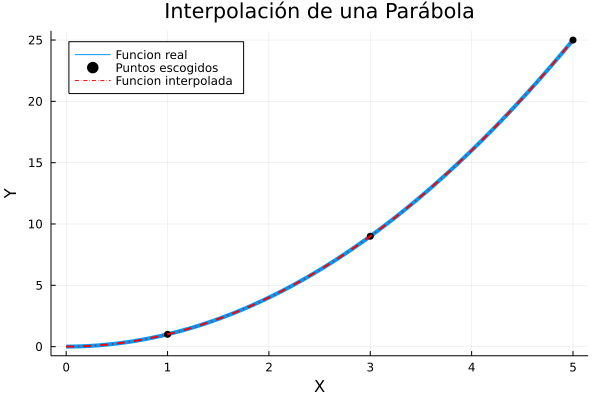

In [3]:
## Plotear los datos que se aproximen a una cuadrática
# Puntos que usaremos para interpolar
x_int = [1, 3, 5] # 3 puntos, entonces se toma un polinomio de orden 2
y_int = x_int.^2
# Interpolacion
y_res = [interlag(x_int,y_int,i) for i in x] # Puntos y calculados con el interpolador de Lagrange
plot(x,y,label = "Funcion real",lw = 4)
plot!([x_int],[y_int],label = "Puntos escogidos",seriestype = :scatter, color = :black,legend = :topleft)
plot!(x,y_res,label="Funcion interpolada",lw = 2,linestyle = :dashdot, color = :red)
title!("Interpolación de una Parábola")
xlabel!("X")
ylabel!("Y")

Como se puede notar, el polinomio interpolador de Lagrange funciona perfectamente para una parábola. Ahora se puede analizar qué pasa si se escogen más puntos para el caso de una función un poco más compleja

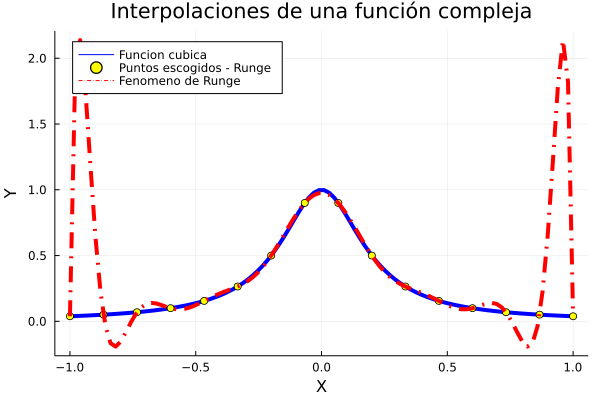

In [28]:
f(x) = 1/(1+25x^2)
x_exp = LinRange(-1,1,100)
y_exp = f.(x_exp)
# Puntos a interpolar mal
x_intmal = LinRange(-1,1,16)
y_intmal = f.(x_intmal)
y_resmal = [interlag(x_intmal,y_intmal,i) for i in x_exp]
plot(x_exp,y_exp,label = "Funcion cubica",color = :blue, legend = :topleft,lw = 4)
plot!(x_intmal,y_intmal,seriestype = :scatter, color = :yellow, label = "Puntos escogidos - Runge")

plot!(x_exp,y_resmal,label = "Fenomeno de Runge", lw = 4, linestyle = :dashdot, color = :red)
ylabel!("Y")
xlabel!("X")
title!("Interpolaciones de una función compleja")

Como se puede notar, no siempre es conveniente usar un interpolador de Lagrange para funciones complejas, más aun cuando se requiere utilizar otros métodos computacionales.


## Interpolaciones con el paquete `Interpolations.jl`

Ahora que se conoce la lógica detrás de uno de los más comunes métodos numéricos, se pasa a usar el paquete previamente mencionado para realizar estos procedimientos de una manera más rápida y efectiva. Cuando se tiene una gran cantidad de puntos, se puede aproximar a una interpolacion lineal. A continuación se podra ver un ejemplo de visualización, para un polinomio $y = 4x^3 - 100x + 6$.

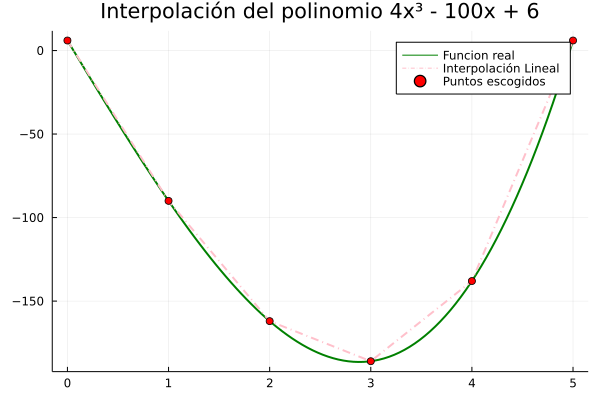

In [29]:
using Interpolations
using Plots
xl = 0:1:5 # El dominio debe declararse de esta manera
f(x) = 4x^3 - 100x + 6
yl = f.(xl)
# Este constructor retorna una función que al evaluarse en cierto punto da el valor de la interpolacion
interp_lineal = LinearInterpolation(xl,yl) 
x_real = LinRange(0,5,100)
y_real = f.(x_real)
y_interp = [interp_lineal(x) for x in x_real]
plot(x_real, y_real, lw = 2, color = :green, label = "Funcion real")
plot!(x_real,y_interp, lw = 2, color = :pink, label = "Interpolación Lineal",linestyle = :dashdot)
plot!(xl,yl,seriestype = :scatter, label = "Puntos escogidos", color = :red)
title!("Interpolación del polinomio 4x³ - 100x + 6")

Como se puede ver, las interpolaciones lineales usando muy pocos puntos puede dar paso a errores numéricos, para contrarrestar esto, se pueden escoger más puntos:

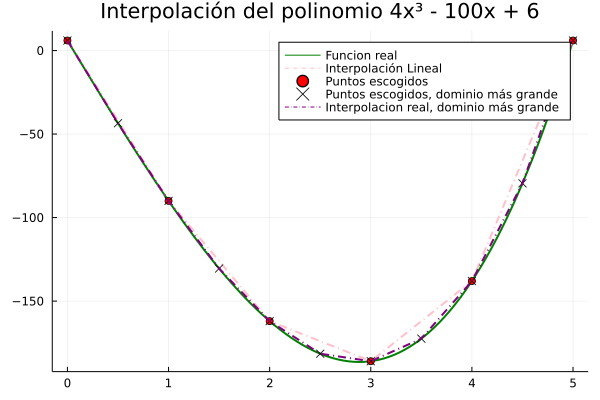

In [30]:
xl2 = 0:0.5:5 #Dominio con el doble de puntos
yl2 = f.(xl2)
interp_lineal = LinearInterpolation(xl2,yl2)
y_interp2 = [interp_lineal(x) for x in x_real]
plot!(xl2,yl2,seriestype = :scatter, label = "Puntos escogidos, dominio más grande", markershape = :x, color = :black)
plot!(x_real,y_interp2, lw = 2, color = :purple, label = "Interpolacion real, dominio más grande", linestyle = :dashdot)

A continuación se puede ver el error en cada caso:

In [31]:
error1 = [abs(i[1] - i[2]) for i in zip(y_interp,y_real)]
println("El error máximo en el primer caso de interpolación lineal es del ", round(maximum(error1),digits = 2), "%" )
error2 = [abs(i[1] - i[2]) for i in zip(y_interp2,y_real)]
println("El error máximo en el segundo caso de interpolación lineal es del ", round(maximum(error2),digits = 2), "%" )

El error máximo en el primer caso de interpolación lineal es del 13.49%
El error máximo en el segundo caso de interpolación lineal es del 3.56%


Como se puede notar, al escogerse más puntos se minimiza el error. Sin embargo, se puede realizar otro tipo de ajuste preciso sin la necesidad de escoger una gran variedad de puntos. Para esto, se usan diferentes funciones de los paquetes `Interpolations.jl` y `Dierckx.jl`, con la posibilidad de  diferentes algoritmos de interpolación. Para más información, se pueden consultar las documentaciones estables de los paquetes:

http://juliamath.github.io/Interpolations.jl/stable/control/

https://github.com/kbarbary/Dierckx.jl


Se pueden controlar las interpolaciones mediante los parámetros especiales de la función `interpolate(x,y,options..)` donde el ultimo parámetro hace referencia al algoritmo de interpolación. A continuación se pueden apreciar diferentes tipos.

## Vecino más cercano (nearest - neighbour)

Este es un caso de interpolación poco común (en algunas ocaciones conocido como NN), en la que se tiene una serie de datos y se retorna el valor más cercano dentro de la serie de datos a interpolar. Se puede notar un ejemplo de visualización con la función $y = \sin{x}$.

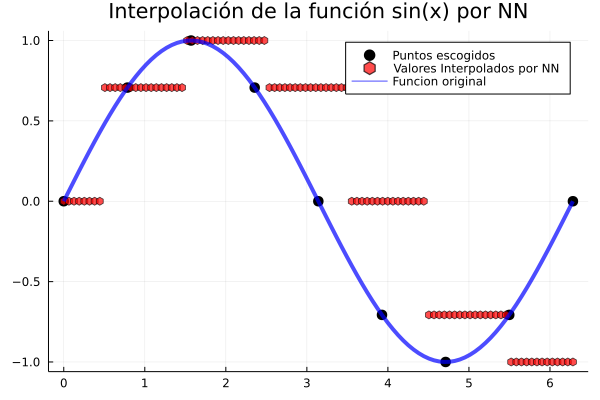

In [32]:
ynn = [sin(i) for i in 0:π/4:2π]
itp = interpolate(ynn, BSpline(Constant())) # Creación del objeto interpolador
ynn_interp = [itp(i+1) for i in LinRange(0,2π,100)]
plot(0:π/4:2π, ynn, seriestype = :scatter, label = "Puntos escogidos", color = :black,markersize = 6)
plot!(LinRange(0,2π,100), ynn_interp, seriestype = :scatter , markershape = :hexagon, color = :red, markeralpha = 0.7, label = "Valores Interpolados por NN")
plot!(LinRange(0,2π,100), [sin(i) for i in LinRange(0,2π,100)], label = "Funcion original", lw = 4, color = :blue, alpha = 0.7)
title!("Interpolación de la función sin(x) por NN")

## Interpolación por Splines

En este caso, se trata de un tipo de interpolación más preciso, en el que se pueden usar puntos que no son necesariamente espaciados uniformemente. A continuación se podrá mostrar el proceso y observar un ejemplo de visualización mediante el mismo ejemplo anterior. La función base de este ejercicio es ``Spline1D(x,y;k,bc)`` donde los parámetros a entrar son los puntos en x, puntos en y, el grado del _spline_ (de 1 a 5, con un valor por defecto de 3), y el comportamiento de frontera. Este ultimo incluye 3 opciones: ``"nearest``, `"zero`, `"extrapolate"`, `"error"`. En problemas de ingerniería, lo más común es extrapolar los valores, es decir, predecir resultados fuera del dominio usado en la interpolación. 

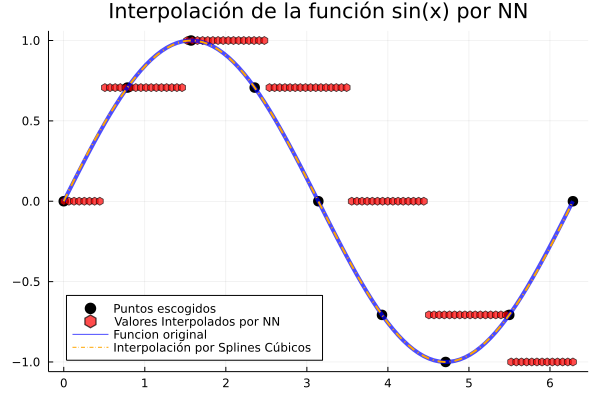

In [33]:
using Dierckx
x_int = 0:π/4:2π
y_int = [sin(x) for x in x_int]
itp = Spline1D(x_int,y_int,k = 3, bc = "extrapolate") # Declaración del objeto interpolador
dominio = LinRange(0,2π,100) # Dominio a graficar
plot!(dominio, itp.(dominio), lw = 2, linestyle = :dashdot, color = :orange, label = "Interpolación por Splines Cúbicos", legend=:bottomleft)

A continuación se podrá encontrar el error porcentual del método de Splines Cúbicos. 

In [34]:
error = [abs(i[1] - i[2]) for i in zip(itp.(dominio),sin.(dominio))]
println("El error máximo del método de Splines es del ", round(maximum(error)*100,digits = 2)," %")

El error máximo del método de Splines es del 0.77 %


En resumen, se puede notar que cada método de interpolación tiene sus pros y sus contras, y es criterio del ingeniero escoger el método que más se ajuste a las necesidades del problema. Un método con mayor exactitud tiende a tener un costo computacional más alto.

# Taller

Para esta semana, se requiere crear tres funciones que puedan recrear las tres curvas de cabeza contra caudal. Opcionalmente se puede recrear la gráfica con el fin de comparar resultados. La función debe retornar un DataFrame donde cada columna sea las series a interpolar y los datos de las columnas los valores calculados con el objeto interpolador.

In [35]:
function interpolaciones_curvas()
    # Escribir código aqui
end;